# DMDc and tlsDMDc for vehicle dynamics identifications

In [1]:
m = 1575;
Iz = 2875;
lf = 1.2;
lr = 1.6;
Cf = 19000;
Cr = 33000;
Vx = 2;
%vy & omega
Ac = [-(2*Cf+2*Cr)/m/Vx, -Vx-(2*Cf*lf-2*Cr*lr)/m/Vx;...
     -(2*Cf*lf-2*Cr*lr)/Iz/Vx, -(2*Cf*lf^2+2*Cr*lr^2)/Iz/Vx];
Bc = [2*Cf/m, 2*Cf*lf/Iz]';
Ac
Bc


Ac =

  -33.0159   17.0476
   10.4348  -38.9009


Bc =

   24.1270
   15.8609




In [2]:
C = eye(2);
sysFull = ss(Ac,Bc,C,0);
Ts = 0.1;
sysDiscrete = c2d(sysFull,Ts);
A = sysDiscrete.A
B = sysDiscrete.B
%A = [1.5 0;0 0.1];
EigsTrue = eig(A)

x0 = [0 0]';
Nsteps = 100;
x(:,1) = x0;
t = 0:Ts:((Nsteps-1)*Ts);
u =3*sin(t);%  ones(1,Nsteps); %


A =

    0.0681    0.0627
    0.0384    0.0464


B =

    0.9743
    0.6263


EigsTrue =

    0.1075
    0.0070




In [3]:
%Attain noise-free data
for kk = 1:(Nsteps-1)
    %u(:,kk) = -x(1,kk);
    x(:,kk+1) = A*x(:,kk)+B*u(kk);
end
X = x(:,1:(end-1));
Xp = x(:,2:end);
Ups = u(:,1:(end-1));
[Ar,Br,~,~] = DMDc_SS(x,Ups);
[Ahat, Bhat,~,~] = DMDcExt(X, Xp, Ups, 2);
[Atls,Btls]=dmdc_tls(x,Ups,3);% this two matrix should be same as Ahat and Bhat
Ahat
Bhat
Atls
Btls


Ahat =

    0.0681    0.0627
    0.0384    0.0464


Bhat =

    0.9743
    0.6263


Atls =

    0.0681    0.0627
    0.0384    0.0464


Btls =

    0.9743
    0.6263





Ahat =

    0.0134    0.1422
    0.0270    0.0814


Bhat =

    0.9772
    0.6148


Atls =

   -0.4021    0.7770
   -0.6305    1.0878


Btls =

    0.9857
    0.6268




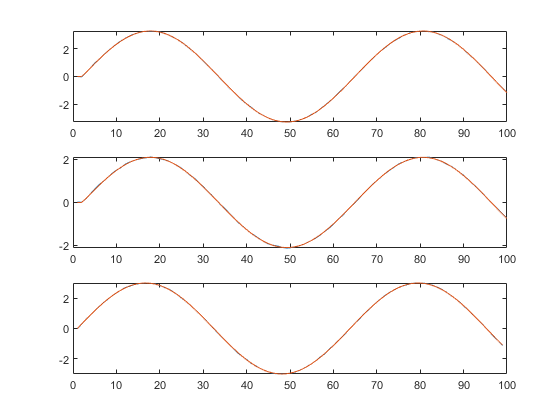

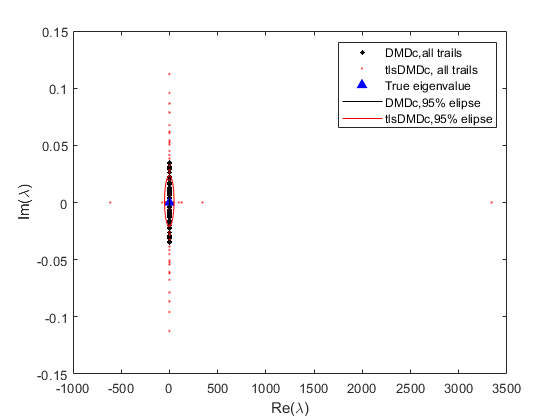

In [4]:
%% add noise with SNR
X = x0;
Xp = x0;
Upsn = 0;
xn = awgn(x,40);%beta0+noise_slip;
Upsn = awgn(Ups,40);
X = xn(:,1:(end-1));
Xp = xn(:,2:end);
figure,subplot(3,1,1),plot(xn(1,:));hold on
subplot(3,1,2),plot(xn(2,:));hold on
subplot(3,1,3),plot(Upsn);hold on
subplot(3,1,1),plot(x(1,:));hold on
subplot(3,1,2),plot(x(2,:));hold on
subplot(3,1,3),plot(Ups);

[Ahat, Bhat,~,~] = DMDcExt(X, Xp, Upsn, 2)
ErrorNormA_Clas = norm(A-Ahat,'fro');
[Atls,Btls]=dmdc_tls(xn,Upsn,3)
ErrorNormA_tls = norm(A-Atls,'fro');

Ntrials = 1000;
EigsNaive = zeros(2,Ntrials);
EigsTLS = zeros(2,Ntrials);
for nn = 1:Ntrials      
    xn = awgn(x,40);%beta0+noise_slip;
    Upsn = awgn(u,40);       
    X = xn(:,1:(end-1));
    Xp = xn(:,2:end);
    Upsn = Upsn(:,1:(end-1));
    [Ahat, Bhat,~,~] = DMDcExt(X, Xp, Upsn, 2);
    EigsNaive(:,nn) = sort(eig(Ahat));
    [Atls,Btls]=dmdc_tls(xn,Upsn,3);
    EigsTLS(:,nn) = sort(eig(Atls));
end
figure,
    H1=plot(real((squeeze(EigsNaive(:,:)))),imag((squeeze(EigsNaive(:,:)))),'k*','Markersize',3);
    hold on
    H2=plot(real((squeeze(EigsTLS(:,:)))),imag((squeeze(EigsTLS(:,:)))),'r.','Markersize',3);
    hold on
    H3=plot(real(eig(A)),imag(eig(A)),'b^','MarkerFaceColor','b');
    ylabel('Im(\lambda)')%,'Interpreter','Latex')
    xlabel('Re(\lambda)')%,'Interpreter','Latex')
    % xlim([0.96 0.963])
    % ylim([0 0.02])
legend([H1(1) H2(1) H3(1)],'DMDc,all trails','tlsDMDc, all trails','True eigenvalue');

tmpx = real((squeeze(EigsNaive(:,:))));
tmpx = tmpx(1,:);
tmpy = imag((squeeze(EigsNaive(:,:))));
tmpy = tmpy(2,:);
X=[tmpx;tmpy]';
h4 = plot_ellipsoid(X,'k');

tmpx = real((squeeze(EigsTLS(:,:))));
tmpx = tmpx(1,:);
tmpy = imag((squeeze(EigsTLS(:,:))));
tmpy = tmpy(2,:);
X=[tmpx;tmpy]';
h5 = plot_ellipsoid(X,'r');
legend([H1(1) H2(1) H3(1) h4 h5],...
    'DMDc,all trails','tlsDMDc, all trails','True eigenvalue',...
    'DMDc,95% elipse', 'tlsDMDc,95% elipse');

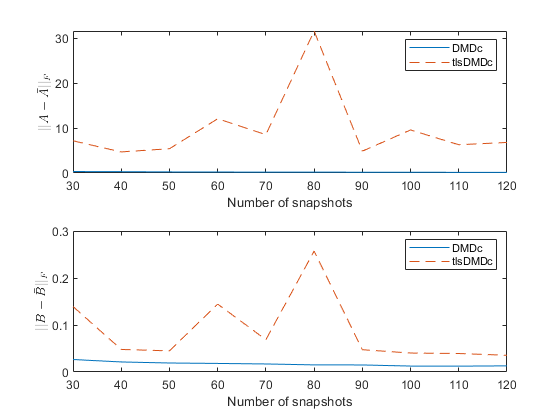

In [5]:
%% change the snaps number
% discussion: more snapshots is better for Sys idenfication
% tlsDMDc is beneficial from the big data, for limited data, the DMD maybe
% better.
Ntrials = 100;
cnt = 1;
trails = 10;%0.6:0.2:3
EigsNaive = zeros(2,trails,Ntrials);
EigsTLS = zeros(2,trails,Ntrials);
ErrorNormA_clas_tmp=zeros(1,Ntrials);
ErrorNormA_tls_tmp=zeros(1,Ntrials);
ErrorNormB_clas_tmp=zeros(1,Ntrials);
ErrorNormB_tls_tmp=zeros(1,Ntrials);
ErrorNormA_clas_mean=zeros(1,trails);
ErrorNormA_tls_mean=zeros(1,trails);
ErrorNormB_clas_mean=zeros(1,trails);
ErrorNormB_tls_mean=zeros(1,trails);

for Nsteps = 30:10:120
    u = 0;
    X = x0;
    Xp = x0;
    Upsn = 0;
    x = x0;
    t = 0:Ts:((Nsteps-1)*Ts);
    u = 5*sin(t);
    for kk = 1:(Nsteps-1)
        x(:,kk+1) = A*x(:,kk)+B*u(kk);
    end
    for nn = 1:Ntrials      
        xn = awgn(x,30);%beta0+noise_slip;
        Upsn = awgn(u,30);       
        X = xn(:,1:(end-1));
        Xp = xn(:,2:end);
        Upsn = Upsn(:,1:(end-1));
        [Ahat, Bhat,~,~] = DMDcExt(X, Xp, Upsn, 2);
        EigsNaive(:,cnt,nn) = sort(eig(Ahat));
        ErrorNormA_clas_tmp(nn) = norm(A-Ahat,'fro');
        ErrorNormB_clas_tmp(nn) = norm(B-Bhat,'fro');
        [Atls,Btls]=dmdc_tls(xn,Upsn,3);
        EigsTLS(:,cnt,nn) = sort(eig(Atls));
        ErrorNormA_tls_tmp(nn) = norm(A-Atls,'fro');
        ErrorNormB_tls_tmp(nn) = norm(B-Btls,'fro');
    end
    ErrorNormA_clas_mean(cnt)=mean(ErrorNormA_clas_tmp);
    ErrorNormB_clas_mean(cnt)=mean(ErrorNormB_clas_tmp);
    ErrorNormA_tls_mean(cnt)=mean(ErrorNormA_tls_tmp);
    ErrorNormB_tls_mean(cnt)=mean(ErrorNormB_tls_tmp);
    cnt = cnt+1;
end
figure,subplot(2,1,1),plot(30:10:120,ErrorNormA_clas_mean)
hold on
plot(30:10:120,ErrorNormA_tls_mean,'--');legend('DMDc','tlsDMDc');
xlabel('Number of snapshots')
ylabel('$||A-\bar{A}||_F$','Interpreter','LaTex')
subplot(2,1,2),plot(30:10:120,ErrorNormB_clas_mean)
hold on
plot(30:10:120,ErrorNormB_tls_mean,'--');legend('DMDc','tlsDMDc');
xlabel('Number of snapshots')
ylabel('$||B-\bar{B}||_F$','Interpreter','LaTex')


## another example

In [6]:
clear all;
m = 9500;%kg
Iz = 18500;%kg-m^2
lf = 1.95;
lr = 1.0;%m
Cf = 1200;%N/deg
Cr = 2500;%N/deg
Vx = 2;

%vy & omega
Ac = [-(2*Cf+2*Cr)/m/Vx, -Vx-(2*Cf*lf-2*Cr*lr)/m/Vx;...
     -(2*Cf*lf-2*Cr*lr)/Iz/Vx, -(2*Cf*lf^2+2*Cr*lr^2)/Iz/Vx];
Bc = [2*Cf/m, 2*Cf*lf/Iz]';

C = eye(2);
sysFull = ss(Ac,Bc,C,0);
Ts = 0.1;
sysDiscrete = c2d(sysFull,Ts);
A = sysDiscrete.A;
B = sysDiscrete.B;
%A = [1.5 0;0 0.1];
EigsTrue = eig(A)

x0 = [0 0]';
Nsteps = 100;
x(:,1) = x0;
t = 0:Ts:((Nsteps-1)*Ts);
u =3*sin(t);%  ones(1,Nsteps); %


EigsTrue =

   0.9621 + 0.0126i
   0.9621 - 0.0126i





Ahat =

    0.9612   -0.1907
    0.0005    0.9616


Bhat =

    0.0226
    0.0251


Atls =

    0.9614   -0.1906
    0.0007    0.9623


Btls =

    0.0226
    0.0249




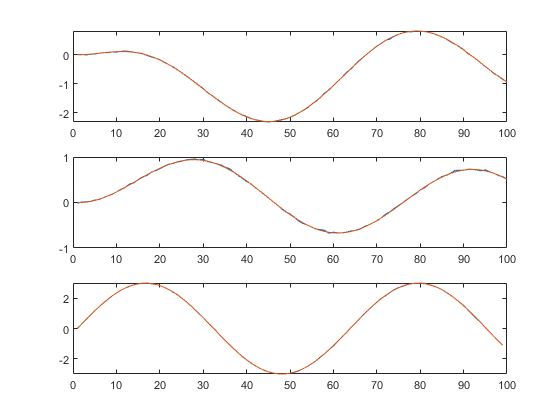

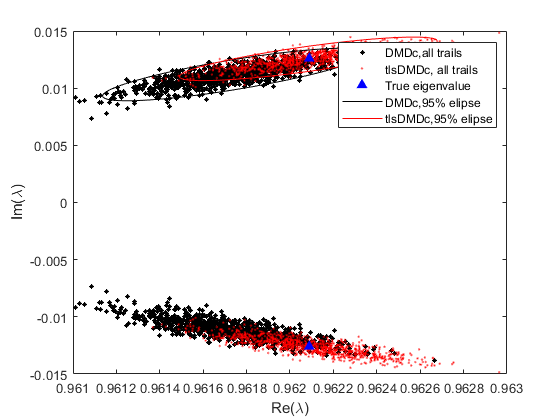

In [8]:
%Attain noise-free data
for kk = 1:(Nsteps-1)
    %u(:,kk) = -x(1,kk);
    x(:,kk+1) = A*x(:,kk)+B*u(kk);
end
X = x(:,1:(end-1));
Xp = x(:,2:end);
Ups = u(:,1:(end-1));
[Ar,Br,~,~] = DMDc_SS(x,Ups);
[Ahat, Bhat,~,~] = DMDcExt(X, Xp, Ups, 2);
[Atls,Btls]=dmdc_tls(x,Ups,3);% this two matrix should be same as Ahat and Bhat
%% add noise with SNR
X = x0;
Xp = x0;
Upsn = 0;
xn = awgn(x,40);%beta0+noise_slip;
Upsn = awgn(Ups,40);
X = xn(:,1:(end-1));
Xp = xn(:,2:end);
figure,subplot(3,1,1),plot(xn(1,:));hold on
subplot(3,1,2),plot(xn(2,:));hold on
subplot(3,1,3),plot(Upsn);hold on
subplot(3,1,1),plot(x(1,:));hold on
subplot(3,1,2),plot(x(2,:));hold on
subplot(3,1,3),plot(Ups);

[Ahat, Bhat,~,~] = DMDcExt(X, Xp, Upsn, 2)
ErrorNormA_Clas = norm(A-Ahat,'fro');
[Atls,Btls]=dmdc_tls(xn,Upsn,3)
ErrorNormA_tls = norm(A-Atls,'fro');

Ntrials = 1000;
EigsNaive = zeros(2,Ntrials);
EigsTLS = zeros(2,Ntrials);
for nn = 1:Ntrials      
    xn = awgn(x,40);%beta0+noise_slip;
    Upsn = awgn(u,40);       
    X = xn(:,1:(end-1));
    Xp = xn(:,2:end);
    Upsn = Upsn(:,1:(end-1));
    [Ahat, Bhat,~,~] = DMDcExt(X, Xp, Upsn, 2);
    EigsNaive(:,nn) = sort(eig(Ahat));
    [Atls,Btls]=dmdc_tls(xn,Upsn,3);
    EigsTLS(:,nn) = sort(eig(Atls));
end
figure,
    H1=plot(real((squeeze(EigsNaive(:,:)))),imag((squeeze(EigsNaive(:,:)))),'k*','Markersize',3);
    hold on
    H2=plot(real((squeeze(EigsTLS(:,:)))),imag((squeeze(EigsTLS(:,:)))),'r.','Markersize',3);
    hold on
    H3=plot(real(eig(A)),imag(eig(A)),'b^','MarkerFaceColor','b');
    ylabel('Im(\lambda)')%,'Interpreter','Latex')
    xlabel('Re(\lambda)')%,'Interpreter','Latex')
    % xlim([0.96 0.963])
    % ylim([0 0.02])
legend([H1(1) H2(1) H3(1)],'DMDc,all trails','tlsDMDc, all trails','True eigenvalue');

tmpx = real((squeeze(EigsNaive(:,:))));
tmpx = tmpx(1,:);
tmpy = imag((squeeze(EigsNaive(:,:))));
tmpy = tmpy(2,:);
X=[tmpx;tmpy]';
h4 = plot_ellipsoid(X,'k');

tmpx = real((squeeze(EigsTLS(:,:))));
tmpx = tmpx(1,:);
tmpy = imag((squeeze(EigsTLS(:,:))));
tmpy = tmpy(2,:);
X=[tmpx;tmpy]';
h5 = plot_ellipsoid(X,'r');
legend([H1(1) H2(1) H3(1) h4 h5],...
    'DMDc,all trails','tlsDMDc, all trails','True eigenvalue',...
    'DMDc,95% elipse', 'tlsDMDc,95% elipse');

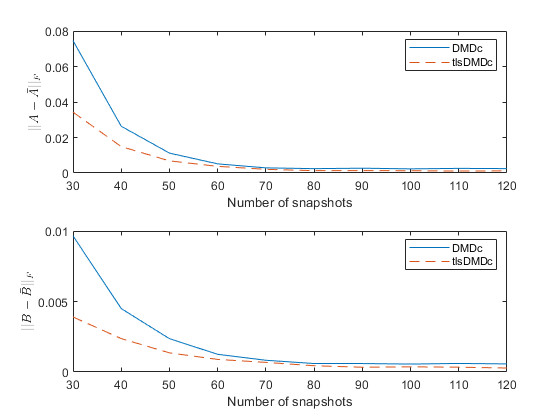

In [9]:
%% change the snaps number
% discussion: more snapshots is better for Sys idenfication
% tlsDMDc is beneficial from the big data, for limited data, the DMD maybe
% better.
Ntrials = 100;
cnt = 1;
trails = 10;%0.6:0.2:3
EigsNaive = zeros(2,trails,Ntrials);
EigsTLS = zeros(2,trails,Ntrials);
ErrorNormA_clas_tmp=zeros(1,Ntrials);
ErrorNormA_tls_tmp=zeros(1,Ntrials);
ErrorNormB_clas_tmp=zeros(1,Ntrials);
ErrorNormB_tls_tmp=zeros(1,Ntrials);
ErrorNormA_clas_mean=zeros(1,trails);
ErrorNormA_tls_mean=zeros(1,trails);
ErrorNormB_clas_mean=zeros(1,trails);
ErrorNormB_tls_mean=zeros(1,trails);

for Nsteps = 30:10:120
    u = 0;
    X = x0;
    Xp = x0;
    Upsn = 0;
    x = x0;
    t = 0:Ts:((Nsteps-1)*Ts);
    u = 5*sin(t);
    for kk = 1:(Nsteps-1)
        x(:,kk+1) = A*x(:,kk)+B*u(kk);
    end
    for nn = 1:Ntrials      
        xn = awgn(x,30);%beta0+noise_slip;
        Upsn = awgn(u,30);       
        X = xn(:,1:(end-1));
        Xp = xn(:,2:end);
        Upsn = Upsn(:,1:(end-1));
        [Ahat, Bhat,~,~] = DMDcExt(X, Xp, Upsn, 2);
        EigsNaive(:,cnt,nn) = sort(eig(Ahat));
        ErrorNormA_clas_tmp(nn) = norm(A-Ahat,'fro');
        ErrorNormB_clas_tmp(nn) = norm(B-Bhat,'fro');
        [Atls,Btls]=dmdc_tls(xn,Upsn,3);
        EigsTLS(:,cnt,nn) = sort(eig(Atls));
        ErrorNormA_tls_tmp(nn) = norm(A-Atls,'fro');
        ErrorNormB_tls_tmp(nn) = norm(B-Btls,'fro');
    end
    ErrorNormA_clas_mean(cnt)=mean(ErrorNormA_clas_tmp);
    ErrorNormB_clas_mean(cnt)=mean(ErrorNormB_clas_tmp);
    ErrorNormA_tls_mean(cnt)=mean(ErrorNormA_tls_tmp);
    ErrorNormB_tls_mean(cnt)=mean(ErrorNormB_tls_tmp);
    cnt = cnt+1;
end
figure,subplot(2,1,1),plot(30:10:120,ErrorNormA_clas_mean)
hold on
plot(30:10:120,ErrorNormA_tls_mean,'--');legend('DMDc','tlsDMDc');
xlabel('Number of snapshots')
ylabel('$||A-\bar{A}||_F$','Interpreter','LaTex')
subplot(2,1,2),plot(30:10:120,ErrorNormB_clas_mean)
hold on
plot(30:10:120,ErrorNormB_tls_mean,'--');legend('DMDc','tlsDMDc');
xlabel('Number of snapshots')
ylabel('$||B-\bar{B}||_F$','Interpreter','LaTex')
